## Use the same blocks for the kawasaki test run analysis
---
### Starting here:

In [1]:
from os.path import join, basename, exists
import os
import yaml
import pandas as pd 
import numpy as np
from glob import glob
%load_ext autoreload
%autoreload 2

In [2]:
from src.config import DATA_DIR, PARAMS_DIR, RESULTS
print(DATA_DIR)


Project Directory: /data2/isshamie/time_neutrophils
/data2/isshamie/time_neutrophils/data


In [3]:
#The parameter file depending on the analysis
parameter_f = join(PARAMS_DIR, "kawasaki", "test_run", "kawasaki_snakemake_001.yaml")
# with open(parameter_f,'r') as f:
#     params = yaml.load(f, Loader=yaml.Loader)
with open(parameter_f, 'r') as f:
    params = yaml.safe_load(f)

print(parameter_f)
print(params)

/data2/isshamie/time_neutrophils/parameters/kawasaki/test_run/kawasaki_snakemake_001.yaml
{'raw_dir': 'raw/kawasaki/FCS Files/', 'prefix': 'kawasaki/test_run', 'tidy_name': 'tidy', 'wells': ['A01', 'A02', 'A04', 'B01', 'B02', 'B04', 'A07'], 'name': {'start': 'Test Run - ', 'end': '.csv'}, 'features': None, 'normalizations': ['log10'], 'reduction': 'umap', 'n_subsample': 100, 'n_iters': 3, 'min_neighbors': [200, 15, 100], 'min_distances': [0], 'cluster_technique': 'hdb', 'min_cluster_size': [30, 60], 'min_sample': [100]}


### Make results directory 

In [4]:
results_dir =  join(RESULTS, params["prefix"])
print(results_dir)
if not exists(RESULTS):
    print(f"{RESULTS} is not made yet! Make that first")

else:
    if not exists(results_dir):
        os.makedirs(results_dir)

/data2/isshamie/time_neutrophils/data/processed/kawasaki/test_run


### Until Here
---
---

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import scipy.stats as stats

### Input files

In [6]:
processed_dir = join(results_dir, "tidy")
data_f = join(processed_dir, "fc.tsv")
meta_f = join(processed_dir, "meta.tsv")

In [7]:
data = pd.read_csv(data_f,sep="\t",index_col=0)
meta = pd.read_csv(meta_f,sep="\t", index_col=0)

In [8]:
attrs = ["Cell Size", "Cell Circularity", "Cell Aspect Ratio", 
         "Cell Tracker Intensity", "PI Intensity", "AnexinV Intensity"]

In [9]:
data_log = np.log10(data[attrs])
print(data_log.shape)
data_log = data_log[(np.abs(stats.zscore(data_log)) < 3).all(axis=1)]
print(data_log.shape)
data = data.loc[data_log.index]

data = pd.concat((data,meta.loc[data.index]), axis=1)
data_log = pd.concat((data_log,meta.loc[data_log.index]), axis=1)

(242851, 6)
(224867, 6)


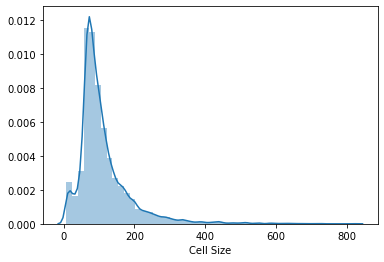

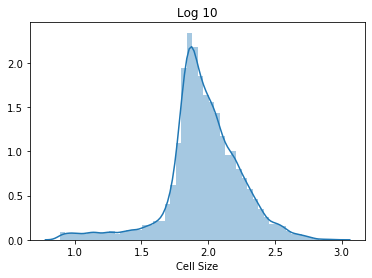

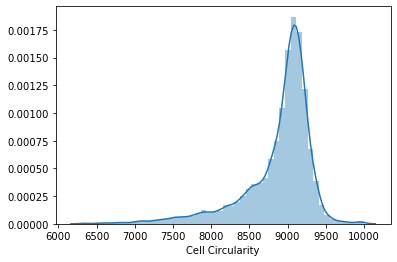

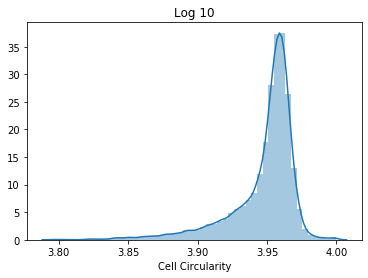

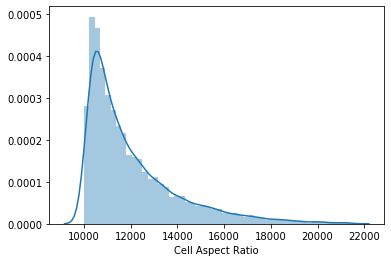

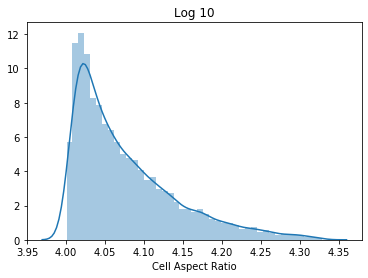

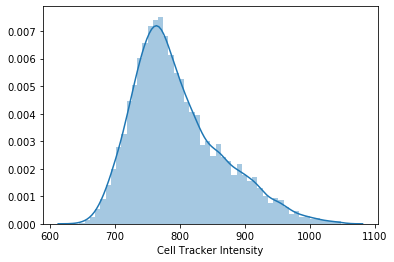

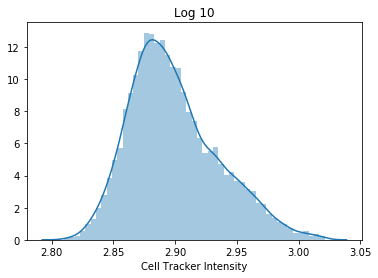

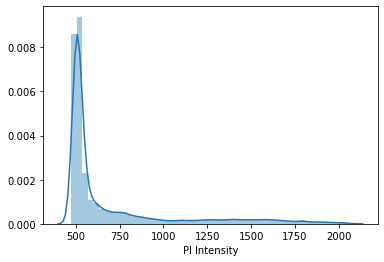

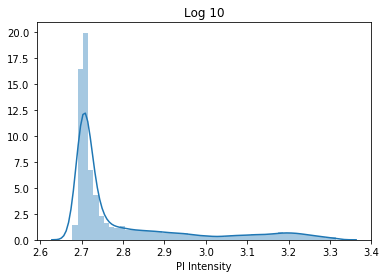

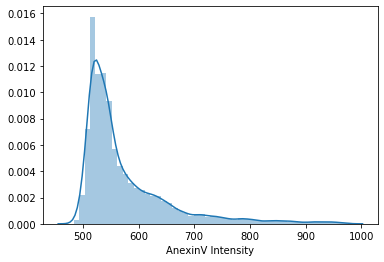

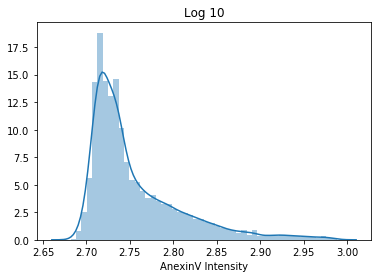

In [10]:
for i in attrs:
    f = plt.figure()
    sns.distplot(data[i].sample(10000))
#     plt.savefig(f"../figures/{''.join(i.split())}_eda_dist.png")
#     plt.savefig(f"../figures/{''.join(i.split())}_eda_dist.pdf")
    f = plt.figure()
    sns.distplot((data_log[i]).sample(10000))
    plt.title("Log 10")
#     plt.savefig(f"../figures/{''.join(i.split())}_eda_log10_dist.png")
#     plt.savefig(f"../figures/{''.join(i.split())}_eda_log10_dist.pdf")

## Create timepoint-by-attribute hexplot  

In [16]:
data_log.head()

,Cell Size,Cell Circularity,Cell Aspect Ratio,Cell Tracker Intensity,PI Intensity,AnexinV Intensity,Sample,Timepoint,Stimuli,Full Sample
0_1_A_1,2.856023,3.890977,4.160059,2.799736,2.687963,2.714959,1,1,A,A_1
1_1_A_1,1.890203,3.953032,4.129227,2.910149,2.693975,2.723751,1,1,A,A_1
2_1_A_1,2.223471,3.954668,4.052147,2.903299,2.696246,2.724940,1,1,A,A_1
3_1_A_1,2.071714,3.959870,4.014399,2.905972,2.695415,2.724021,1,1,A,A_1
5_1_A_1,1.068271,3.985885,4.122861,2.804720,2.689188,2.720563,1,1,A,A_1


In [20]:
data_log["Full Sample"].unique()

array(['A_1', 'A_2', 'A_4', 'B_1', 'B_2', 'B_4', 'A_7'], dtype=object)

A_1
A_2
A_4
A_7
B_1
B_2
B_4


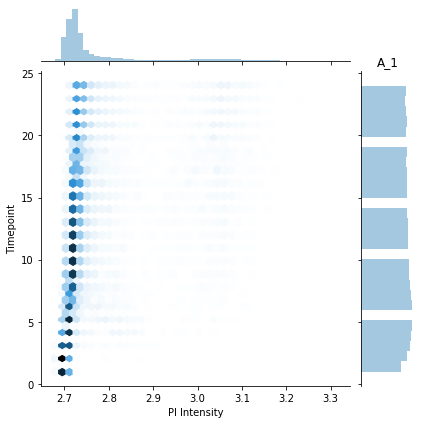

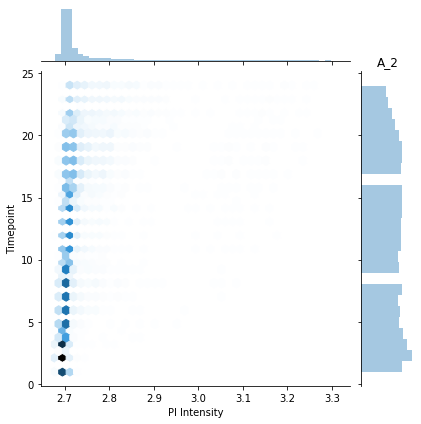

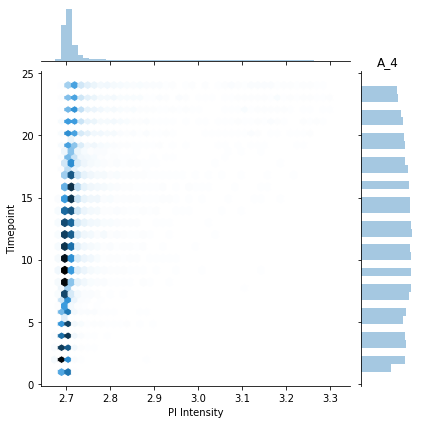

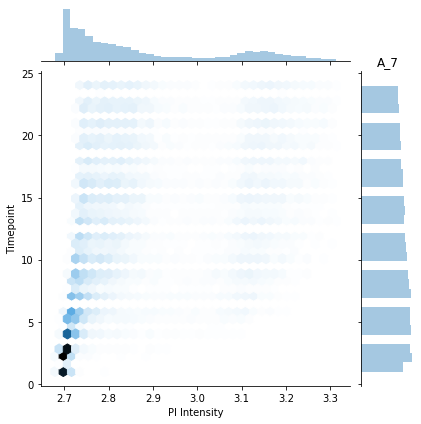

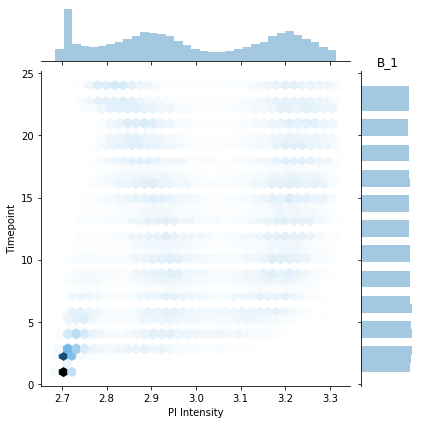

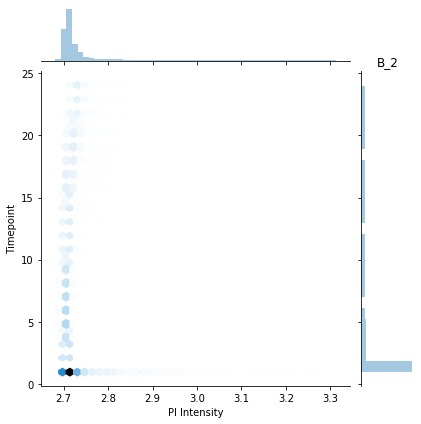

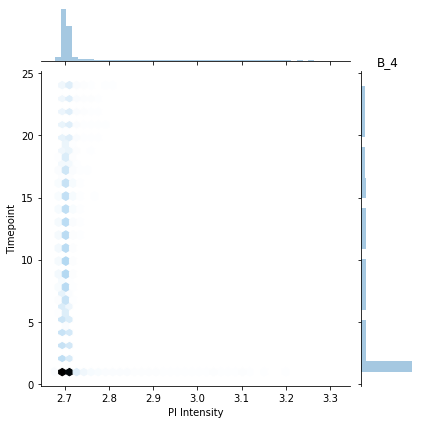

In [24]:
colors= ["blue", "red", "green"]
i = 0
for g, group in data_log.groupby("Full Sample"):
    print(g)
    sns.jointplot(group["PI Intensity"], group["Timepoint"], kind="hex")#,color=colors[i])
    plt.title(g)
    i+=1

In [ ]:
attrs = ["Cell Tracker Intensity", "PI Intensity", "AnexinV Intensity", 
         "Cell Size", "Cell Circularity", "Cell Aspect Ratio"]
x = data_log["Timepoint"]
#y = data_log["PI Intensity"]
xmin = x.min()
xmax = x.max()
# ymin = y.min()
# ymax = y.max()
stimuli = {j:i for i,j in enumerate(data_log["Stimuli"].unique())}

fig, axs = plt.subplots(nrows=len(attrs),ncols=len(stimuli), sharey='row',sharex=True, 
                        figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
for ind, val in data_log.groupby("Stimuli"): #"Stimuli"):
    
    for a_ind,a in enumerate(attrs):
        ax = axs[a_ind, stimuli[ind]]
        x = val["Timepoint"]
        y = val[a]
        ymin = y.min()
        ymax = y.max()
        
        hb = ax.hexbin(x, y, gridsize=48, bins='log', cmap='inferno',vmin=1,vmax=1e5)
        ax.axis([xmin, xmax, ymin, ymax])
        
        if a_ind == len(attrs)-1:
            ax.set_xlabel("Timepoint")
        else: 
            ax.set_xlabel("")
        if a_ind == 0:
            ax.set_title(f"{ind}")
        if stimuli[ind] == 0:
            ax.set_ylabel(a, rotation=0, labelpad=30)
        
        #if a_ind == 0 and stimuli[ind] == 1:
cb = fig.colorbar(hb, ax=axs)
cb.set_label('log10(N)')


#plt.savefig("../figures/tracking_log_features_over_time_stimuli.png")
#plt.savefig("../figures/tracking_log_features_over_time_stiumi.pdf")



In [ ]:
attrs = ["Cell Tracker Intensity", "PI Intensity", "AnexinV Intensity", 
         "Cell Size", "Cell Circularity", "Cell Aspect Ratio"]
x = data_log["Timepoint"]
#y = data_log["PI Intensity"]
xmin = x.min()
xmax = x.max()
# ymin = y.min()
# ymax = y.max()
stimuli = {j:i for i,j in enumerate(data_log["Stimuli"].unique())}

fig, axs = plt.subplots(nrows=len(attrs),ncols=len(stimuli), sharey='row',sharex=True, 
                        figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
for ind, val in data_log.groupby("Stimuli"): #"Stimuli"):
    
    for a_ind,a in enumerate(attrs):
        ax = axs[a_ind, stimuli[ind]]
        x = val["Timepoint"]
        y = val[a]
        ymin = y.min()
        ymax = y.max()
        
        hb = ax.hexbin(x, y, gridsize=40, bins='log', cmap='inferno',vmin=100,vmax=1e5)
        ax.axis([xmin, xmax, ymin, ymax])
        
        if a_ind == len(attrs)-1:
            ax.set_xlabel("Timepoint")
        else: 
            ax.set_xlabel("")
        if a_ind == 0:
            ax.set_title(f"{ind}")
        if stimuli[ind] == 0:
            ax.set_ylabel(a, rotation=0, labelpad=30)
        
        #if a_ind == 0 and stimuli[ind] == 1:
cb = fig.colorbar(hb, ax=axs)
cb.set_label('log10(N)')


#plt.savefig("../figures/tracking_log_features_over_time_stimuli.png")
#plt.savefig("../figures/tracking_log_features_over_time_stiumi.pdf")



In [ ]:
from src.config import DATA_DIR
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
meta = pd.read_csv(os.path.join(DATA_DIR, "meta.tsv"), sep="\t", index_col=0)

meta

In [ ]:
cells_per = meta.groupby(["Stimuli","Sample", "Timepoint"]).size()
cells_per.name = "cells"
cells_per = cells_per.reset_index()

In [ ]:
#sns.violinplot(x="Sample", y = "Timepoint" , data=cells_per)
g = sns.catplot(x="Stimuli", y="cells", row="Timepoint",
                data=cells_per, kind="violin", 
                height=10, aspect=0.7);


In [ ]:
from src.config import FIGURES_DIR

In [ ]:
#g.savefig(os.path.join(FIGURES_DIR,"cell_distribution.png"))
#g.savefig(os.path.join(FIGURES_DIR,"cell_distribution.pdf"))

In [ ]:
sns.violinplot(meta.groupby(["Stimuli","Sample", "Timepoint"]).size())
plt.title("Number of cells per experiment snapshot")

plt.figure()
sns.violinplot(meta.groupby(["Stimuli","Sample"]).size())
plt.title("Number of cells per experiment snapshot")

plt.figure()
sns.violinplot(meta.groupby(["Timepoint","Sample"]).size())
plt.title("Number of cells per timepoint")


In [ ]:
data_log.groupby(["Timepoint", "Stimuli"]).size()

In [ ]:
sns.distplot(data_log.groupby(["Timepoint", "Stimuli"]).size())

In [ ]:
sns.distplot(data_log.groupby(["Timepoint", "Stimuli","Genotype"]).size())